In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

In [2]:
# Load data

df_train = pd.read_csv('DailyDelhiClimateTrain.csv', index_col=0)
df_test = pd.read_csv('DailyDelhiClimateTest.csv', index_col=0)

def normalize(data, min, max):  # https://en.wikipedia.org/wiki/Feature_scaling
    data = data - min
    data = data / max
    return data

df_train = df_train.values
df_train_normed = normalize(df_train, df_train.min(axis=0), df_train.max(axis=0))

df_test = df_test.values
df_test_normed = normalize(df_test, df_train.min(axis=0), df_train.max(axis=0))  # take note here we have to use the train data's min and max else the scaled values are not of the same scale as the training which cause the predictions to be off

In [3]:
def windowed_dataset(series, batch_size, n_past=10, n_future=1, shift=1):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(size=n_past + n_future, shift=shift, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(n_past + n_future))
    ds = ds.map(lambda w: (w[:n_past, :-1], (w[n_past:, :-1], w[n_past:, -1])))
    return ds.batch(batch_size).prefetch(1)

n_past = 20
n_future = 1

train = windowed_dataset(df_train_normed, batch_size=32, n_past=n_past, n_future=n_future, shift=1)
test = windowed_dataset(df_test_normed, batch_size=32, n_past=n_past, n_future=n_future, shift=1)

In [4]:
for i in train:
    print(i)  # you should see a 3 tensors, 1st one is input, (None, n_past, 4), 2nd one is future of the 4 weather metrics: (None, n_future, 4), 3rd one is the comfortable class: (None, n_future, 1)
    break

(<tf.Tensor: shape=(32, 20, 4), dtype=float64, numpy=
array([[[0.10332103, 0.71071429, 0.        , 0.13265583],
        [0.03616236, 0.78571429, 0.07058266, 0.13293363],
        [0.0301353 , 0.73571429, 0.10974262, 0.13304649],
        ...,
        [0.20233702, 0.78738095, 0.21198484, 0.13250391],
        [0.16789668, 0.63238095, 0.13934944, 0.13343715],
        [0.13653137, 0.61857143, 0.20064966, 0.13325732]],

       [[0.03616236, 0.78571429, 0.07058266, 0.13293363],
        [0.0301353 , 0.73571429, 0.10974262, 0.13304649],
        [0.06888069, 0.57904762, 0.02921206, 0.13285116],
        ...,
        [0.16789668, 0.63238095, 0.13934944, 0.13343715],
        [0.13653137, 0.61857143, 0.20064966, 0.13325732],
        [0.13431734, 0.63571429, 0.05258171, 0.13335033]],

       [[0.0301353 , 0.73571429, 0.10974262, 0.13304649],
        [0.06888069, 0.57904762, 0.02921206, 0.13285116],
        [0.        , 0.73404762, 0.08763619, 0.13276435],
        ...,
        [0.13653137, 0.61857143, 

In [5]:
# Model
xIn = Input(shape=(n_past, 4))
x = LSTM(64, return_sequences=True)(xIn)
x = SpatialDropout1D(0.1)(x)
x = LSTM(32, return_sequences=True)(x)
x = SpatialDropout1D(0.1)(x)
x = Dense(32, activation='swish')(x)
x = Dropout(0.1)(x)
x = Dense(32, activation='swish')(x)
x = Dropout(0.1)(x)
xWeatherOut = Dense(n_future, name='weather')(x)
xComfort = Flatten()(xWeatherOut)
xComfort = Dense(32, activation='swish')(xComfort)
xComfort = Dropout(0.1)(xComfort)
xComfortOut = Dense(1, activation='sigmoid', name='comfort')(xComfort)

model = Model(inputs=xIn, outputs=[xWeatherOut, xComfortOut])
model.compile(loss={'weather': 'mse', 'comfort': 'binary_crossentropy'}, loss_weights={'weather': 1, 'comfort': 2}, metrics={'weather': 'mse', 'comfort': 'accuracy'}, optimizer=tf.keras.optimizers.Adam(1e-3))
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20, 4)]           0         
                                                                 
 lstm (LSTM)                 (None, 20, 64)            17664     
                                                                 
 spatial_dropout1d (SpatialD  (None, 20, 64)           0         
 ropout1D)                                                       
                                                                 
 lstm_1 (LSTM)               (None, 20, 32)            12416     
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 20, 32)           0         
 lDropout1D)                                                     
                                                                 
 dense (Dense)               (None, 20, 32)            1056  

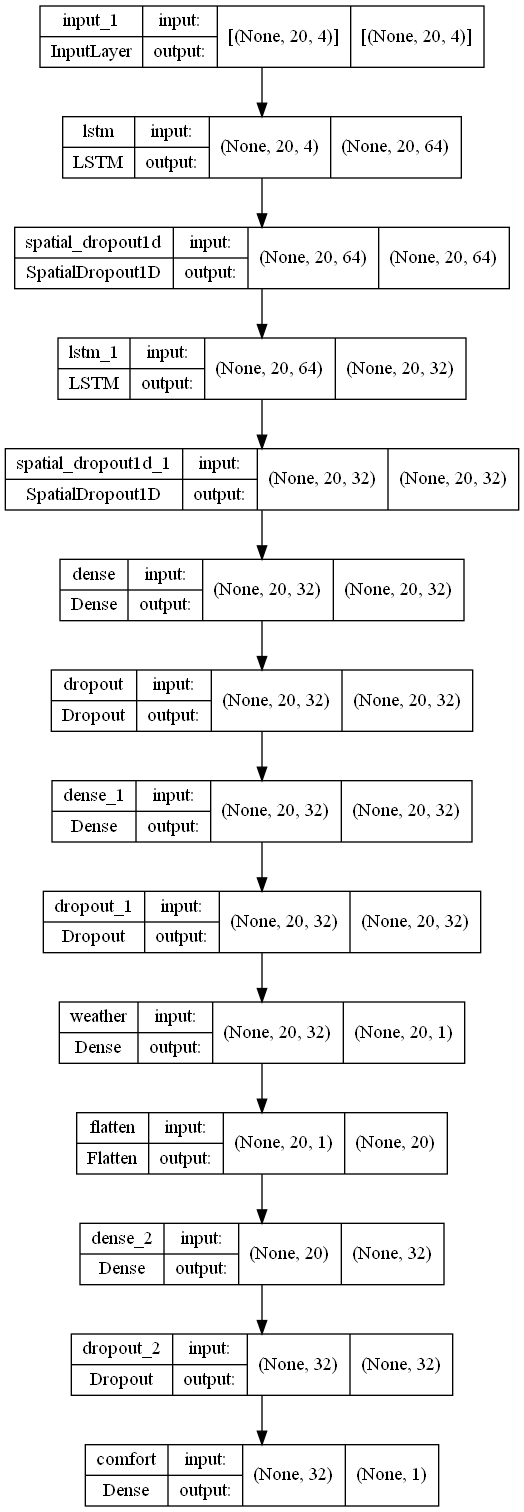

In [6]:
plot_model(model, to_file='model.png', show_shapes=True)

In [7]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10),
]

model.fit(train, epochs=100, validation_data=test, callbacks=callbacks, use_multiprocessing=True)

Epoch 1/100
46/46 [==============================] - 13s 109ms/step - loss: 1.2714 - weather_loss: 0.0821 - comfort_loss: 0.5947 - weather_mse: 0.0821 - comfort_accuracy: 0.7698 - val_loss: 1.1999 - val_weather_loss: 0.0434 - val_comfort_loss: 0.5783 - val_weather_mse: 0.0434 - val_comfort_accuracy: 0.7340 - lr: 0.0010
Epoch 2/100
46/46 [==============================] - 4s 78ms/step - loss: 1.1382 - weather_loss: 0.0639 - comfort_loss: 0.5372 - weather_mse: 0.0639 - comfort_accuracy: 0.7774 - val_loss: 1.1856 - val_weather_loss: 0.0343 - val_comfort_loss: 0.5756 - val_weather_mse: 0.0343 - val_comfort_accuracy: 0.7340 - lr: 0.0010
Epoch 3/100
46/46 [==============================] - 0s 10ms/step - loss: 1.1263 - weather_loss: 0.0552 - comfort_loss: 0.5355 - weather_mse: 0.0552 - comfort_accuracy: 0.7774 - val_loss: 1.1830 - val_weather_loss: 0.0340 - val_comfort_loss: 0.5745 - val_weather_mse: 0.0340 - val_comfort_accuracy: 0.7340 - lr: 0.0010
Epoch 4/100
46/46 [======================

In [8]:
model.save('model')

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets
